In [150]:
%run key_imports.py
%run sabr.py
%run bs.py

In [183]:
"""
Set Parameters
"""
SEED = 42
rng = default_rng(SEED)

"""
Fix Terminal Maturity
"""
N_TIMES = 32
T = 1
dt = T / (N_TIMES)
ts = np.linspace(dt, T, N_TIMES).reshape((1, -1))


"""
Define Paramters
"""
N_SAMPLES = 1000
vol_of_vols = rng.uniform(0, 1, N_SAMPLES).reshape((-1, 1))
betas = rng.uniform(0, 1, N_SAMPLES)
rhos = rng.uniform(0, 1, N_SAMPLES)
V0s = rng.uniform(0.1, 0.3, N_SAMPLES).reshape((-1, 1))


N_BROWNIANS = 2 ** 15
Z1 = rng.standard_normal((N_BROWNIANS, N_TIMES))
Z2 = rng.standard_normal((N_BROWNIANS, N_TIMES))
F0 = 1.0

N_STRIKES = 16
Ks = np.exp(np.linspace(-4.0, 3.0, N_STRIKES)).reshape((1, 1, -1))

"""
Generate dataset via MC
Combine to create dataset
"""
all_calls = []
all_digitals = []

Xs = []
calls = []
digitals = []
feat_names = ['K','ttm',"V", "vol_of_vol","beta", "rho"]
f_to_i = lambda x: feat_names.index(x)


for i in tqdm(range(N_SAMPLES)):
    # exact simulation of the volatility process
    vol_of_vol, beta, rho, V0 = vol_of_vols[i], betas[i], rhos[i], V0s[i] 
    Vt =  np.hstack([V0 * np.exp(-(0.5 * vol_of_vol ** 2) * ts + vol_of_vol * np.sqrt(dt) * np.cumsum(Z2, axis = 1))])
    Ft = np.zeros((N_BROWNIANS, N_TIMES + 1))
    Ft[:,0] = F0 # fix F0 = 1.0

    deltas = np.zeros((N_BROWNIANS, N_TIMES + 1))

    for i in range(N_TIMES):
        Ft[:, i + 1] = cev_step(Ft[:,i], Vt[:,i], beta, dt, Z1[:,i], rho, Z2[:,i])
    
    
    call_surface = np.mean(np.maximum(Ft[:, 1:].reshape((N_BROWNIANS, N_TIMES, 1)) - Ks, 0), axis = 0).T
    digital_surface = np.mean((Ft[:, 1:].reshape((N_BROWNIANS, N_TIMES, 1)) >  Ks), axis = 0).T

    
    temp = np.zeros((N_TIMES * N_STRIKES, 6)) # F, K, ttm, alpha, beta, rho, vol_of_vol
    temp[:, [0, 1]] = np.vstack([np.repeat(Ks, N_TIMES), # strikes
     np.repeat(ts, N_STRIKES).reshape((N_STRIKES, - 1)).T.reshape(-1)]).T
    temp[:, f_to_i("V")] = V0
    temp[:, f_to_i("beta")] = beta
    temp[:, f_to_i("vol_of_vol")] = vol_of_vol
    temp[:, f_to_i("rho")] = rho
    Xs += [temp]
    
    calls += [call_surface.reshape(-1)]
    digitals += [digital_surface.reshape(-1)]
    

Xs = np.concatenate(Xs)
X_df = pd.DataFrame(Xs, columns = feat_names)
X_df['call_MC'] = np.concatenate(calls)
X_df['digital_MC'] = np.concatenate(digitals)

# print(Xs.shape, ys.shape)
assert np.concatenate(calls).shape[0] == Xs.shape[0]
assert np.concatenate(digitals).shape[0] == Xs.shape[0]

"""
Compute SABR approximation
"""
scaling = 1
X_df['sabr_expansion_vols'] = sabr_expansion(F = 1.0, 
               K = X_df['K'].values, 
               vol = X_df['V'].values * scaling ** (X_df['beta'] - 1).values, 
               vol_of_vol= X_df['vol_of_vol'].values, 
               beta = X_df['beta'].values, 
               rho = X_df['rho'].values, 
               ttm = X_df['ttm'].values)
    
X_df['sabr_expansion_BS_call'] = X_df['K'].values * jax_BS_call(SK = -np.log(X_df['K'].values), 
                                             sigma_tau = X_df['sabr_expansion_vols'].values * np.sqrt(X_df['ttm'].values))

X_df['sabr_expansion_BS_digital'] = jax_BS_digital(SK = -np.log(X_df['K'].values), 
                                             sigma_tau = X_df['sabr_expansion_vols'].values * np.sqrt(X_df['ttm'].values))
"""
Writeout to csv
"""
X_df.to_csv("datasets/sabr.csv", index=False)
display(X_df)

  0%|          | 0/1000 [00:00<?, ?it/s]

,K,ttm,V,vol_of_vol,beta,rho,call_MC,digital_MC,sabr_expansion_vols,sabr_expansion_BS_call,sabr_expansion_BS_digital
0,0.018316,0.03125,0.265844,0.773956,0.062063,0.842732,0.987175,1.0,0.724372,9.816844e-01,1.000000e+00
1,0.018316,0.09375,0.265844,0.773956,0.062063,0.842732,0.992472,1.0,0.739438,9.816844e-01,1.000000e+00
2,0.018316,0.15625,0.265844,0.773956,0.062063,0.842732,0.997667,1.0,0.754504,9.816844e-01,1.000000e+00
3,0.018316,0.21875,0.265844,0.773956,0.062063,0.842732,1.003534,1.0,0.769571,9.816844e-01,1.000000e+00
4,0.018316,0.28125,0.265844,0.773956,0.062063,0.842732,1.009032,1.0,0.784637,9.816844e-01,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...
511995,20.085537,0.75000,0.136071,0.280896,0.520072,0.098080,0.000000,0.0,0.246825,0.000000e+00,0.000000e+00
511996,20.085537,0.81250,0.136071,0.280896,0.520072,0.098080,0.000000,0.0,0.246929,0.000000e+00,0.000000e+00
511997,20.085537,0.87500,0.136071,0.280896,0.520072,0.098080,0.000000,0.0,0.247032,0.000000e+00,0.000000e+00
511998,20.085537,0.93750,0.136071,0.280896,0.520072,0.098080,0.000000,0.0,0.247136,0.000000e+00,5.128713e-37


Text(0.5, 1.0, 'Sample payoffs vs Moneyness')

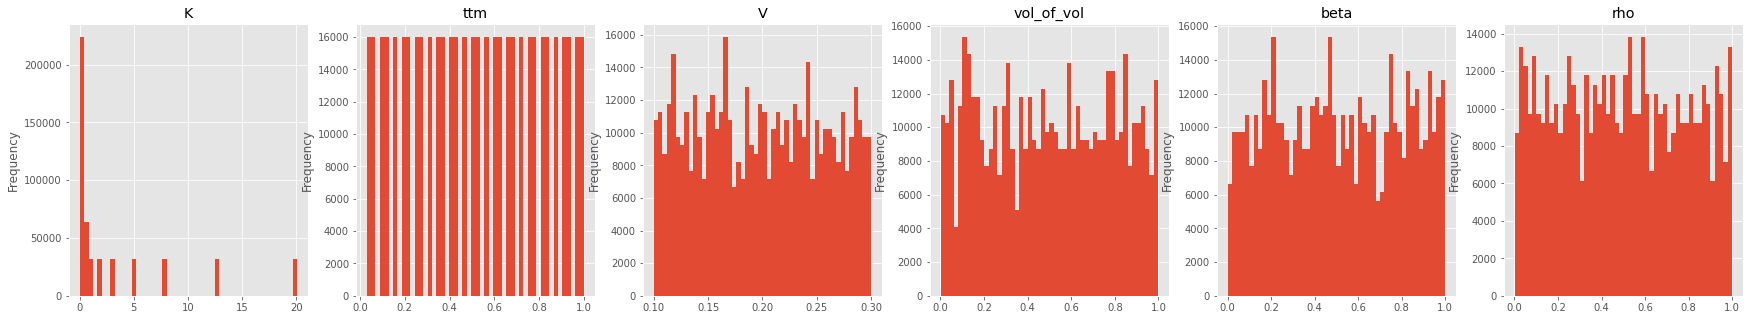

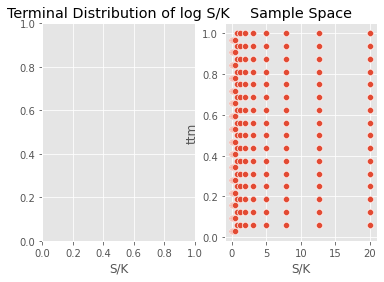

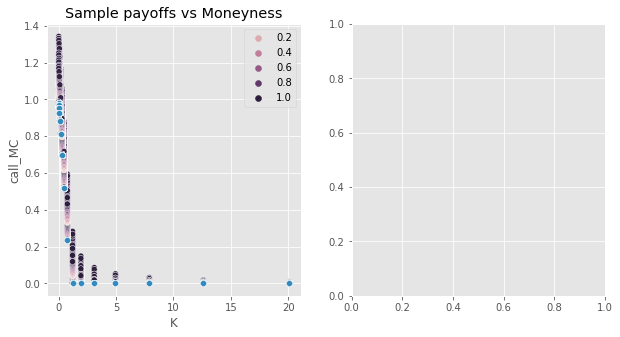

In [184]:
"""
Visualise data
"""
# Marginal Distributions of Parameter Space
fig, ax = plt.subplots(figsize=(5 * len(feat_names), 5), ncols = len(feat_names))
for i in range(len(feat_names)):
    X_df.iloc[:, i].plot(kind = 'hist', ax = ax[i], bins = 50)
    ax[i].set_title(feat_names[i])
# Terminal Distribution of underlying
fig, ax = plt.subplots(ncols = 2)
sns.scatterplot(x = X_df["K"], y = X_df["ttm"], ax = ax[1])
# sns.histplot(Ft[:, -1], ax = ax[0])
ax[0].set_title("Terminal Distribution of log S/K")
ax[0].set_xlabel("S/K")
ax[1].set_title("Sample Space")
ax[1].set_xlabel("S/K")
ax[1].set_ylabel("ttm")
# sample payoff, intrinsic val v S/K

fig, ax = plt.subplots(ncols = 2, figsize=(10, 5))
intrinsic_val = np.maximum(1.0 - X_df["K"], 0)
sns.scatterplot(x = X_df["K"], y = X_df['call_MC'], hue = X_df["ttm"], ax = ax[0])
sns.scatterplot(x = X_df["K"], y = intrinsic_val, ax = ax[0])
ax[0].set_title("Sample payoffs vs Moneyness")
# sns.scatterplot(x = X_df['S/K'], y = X_df['call_true'], hue = X_df['ttm'], ax = ax[1])
# ax[1].set_title("True payoffs vs Monyness")

<AxesSubplot:xlabel='K', ylabel='digital_MC'>

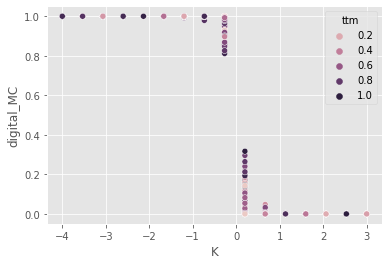

In [185]:
subsample = X_df.sample(1000)
sns.scatterplot(np.log(subsample['K']), subsample['digital_MC'], hue = subsample['ttm'])

Text(0.5, 1.0, 'SABR Expansion vs MC')

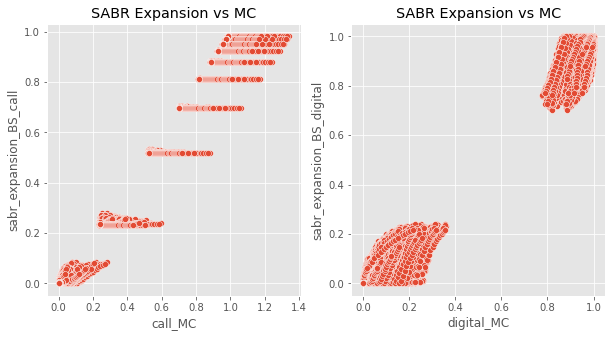

In [186]:
fig, ax = plt.subplots(ncols = 2, figsize=(10, 5))
sns.scatterplot(X_df['call_MC'], X_df['sabr_expansion_BS_call'], ax = ax[0])

sns.scatterplot(X_df['digital_MC'], X_df['sabr_expansion_BS_digital'], ax = ax[1])
ax[0].set_title("SABR Expansion vs MC")
ax[1].set_title("SABR Expansion vs MC")